In [1]:
import numpy as np
from tqdm import tqdm
import pymc as pm
import skfem as fem
from skfem import MeshLine, ElementLineP1, Basis, BilinearForm, LinearForm
from skfem.helpers import dot, grad, d, dd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import truncnorm
import scipy.stats as scstats
import scipy.sparse as scsparse
import scipy.optimize as scoptimize
import scipy.linalg as sclinalg

# import pytensor.tensor.subtensor as subtensor
# import pytensor.tensor as tensor
# import pytensor.sparse as sparsetensor
import arviz as az

import pytensor.tensor as at
from pytensor import function, scan, shared, config, printing
from pytensor import grad as ptgrad
import numpy as np
from tqdm import tqdm
from pytensor import sparse

import scienceplots
# plot params
contour_levels = 10
plt.style.use(['science', 'grid'])
color_list = [(253, 231, 37),(194, 223, 35),(134, 213, 73),(82, 197, 105),(42, 176, 127),(30, 155, 138),(37, 133, 142),(45, 112, 142),(56, 88, 140),(67, 62, 133),(72, 33, 115),(68, 1, 84)]
color_list = [tuple(ti/255 for ti in t) for t in color_list]

In [2]:
import sympy as sp

# Define spatial and temporal variables
x, y, t = sp.symbols('x y t')

# Define scalar variables
rho = sp.symbols(r'\rho')        # Density
dt = sp.symbols(r'\Delta_t')  # Time step
nu = sp.symbols(r'\nu')          # Kinematic viscosity
epsilon = sp.symbols(r'\epsilon')

# Define the scalar functions for velocities and pressure
u = sp.Function(r'u')(x, y, t)  # Velocity in x-direction
v = sp.Function(r'v')(x, y, t)  # Velocity in y-direction
p = sp.Function(r'p')(x, y, t)  # Pressure

u_0 = sp.Function(r'u^n')(x, y)  # Velocity in x-direction
v_0 = sp.Function(r'v^n')(x, y)  # Velocity in y-direction
p_0 = sp.Function(r'p^n')(x, y)  # Pressure

u_1 = sp.Function(r'u^{n+1}')(x, y)  # Velocity in x-direction
v_1 = sp.Function(r'v^{n+1}')(x, y)  # Velocity in y-direction
p_1 = sp.Function(r'p^{n+1}')(x, y)  # Pressure

cn_u = (u_1 - u_0)/dt
cn_v = (v_1 - v_0)/dt
cn_p = (p_1 - p_0)/dt

FEQ1 = (- u*sp.diff(u, x) - v*sp.diff(u,y) -(1/rho)*sp.diff(p, x) + nu*(sp.diff(u, x, 2) + sp.diff(u, y, 2))).expand().doit()

FEQ2 = (- u*sp.diff(v, x) - v*sp.diff(v,y) -(1/rho)*sp.diff(p, y) + nu*(sp.diff(v, x, 2) + sp.diff(v, y, 2))).expand().doit()

FEQ3 = (- sp.diff(p, x, 2) - sp.diff(p, y, 2) -rho*(sp.diff(u, x)**2 + 2*sp.diff(u, y)*sp.diff(v,x) + sp.diff(v,y)**2)).expand().doit()

cn_FEQ1 = (-cn_u + (1/2)*FEQ1.subs([(u, u_1), (v, v_1), (p, p_1)]) + (1/2)*FEQ1.subs([(u, u_0), (v, v_0), (p, p_0)])).expand().doit()
cn_FEQ2 = (-cn_v + (1/2)*FEQ2.subs([(u, u_1), (v, v_1), (p, p_1)]) + (1/2)*FEQ2.subs([(u, u_0), (v, v_0), (p, p_0)])).expand().doit()
cn_FEQ3 = (FEQ3.subs([(u, (1/2)*(u_1+u_0)), (v, (1/2)*(v_1+v_0)), (p, (1/2)*(p_1+p_0))])).expand().doit().expand().doit()

# cn_FEQ1 = (-cn_u + (1/2)*FEQ1.subs([(u, u_0), (v, v_0), (p, p_0)])).expand().doit()
# cn_FEQ2 = (-cn_v + (1/2)*FEQ2.subs([(u, u_0), (v, v_0), (p, p_0)])).expand().doit()
# cn_FEQ3 = (FEQ3.subs([(u, (1/2)*(u_1+u_0)), (v, (1/2)*(v_1+v_0)), (p, (1/2)*(p_1+p_0))])).expand().doit().expand().doit()

def multiply_terms(expr, k_func, j_func):
    new_expr = 0
    for term in expr.as_ordered_terms():
        # Check for velocity terms
        if any([term.has(u_1), term.has(u_0), term.has(v_1), term.has(v_0)]):
            new_expr += k_func * term
        # Check for pressure terms
        elif any([term.has(p_1), term.has(p_0)]):
            new_expr += j_func * term
        else:
            new_expr += term
    return new_expr

# def greens_second_derivative_u_0(expr):
#     # Integrate terms with second derivatives
#     new_expr = expr.replace(
#         lambda term: term.has(sp.diff(u_0, x, 2)*k), 
#         lambda term: sp.diff(term, x, 2) - sp.diff(term, x)
#     )
#     return new_expr

k = sp.Function('k')(x,y)
j = sp.Function('j')(x,y)

n_1 = sp.Function('n_1')(x,y)
n_2 = sp.Function('n_2')(x,y)

# Apply the multiplications: multiply terms with u and v by k, and terms with p by j
cn_FEQ1_modified = multiply_terms(cn_FEQ1.expand(), k, j)
cn_FEQ2_modified = multiply_terms(cn_FEQ2.expand(), k, j)
cn_FEQ3_modified = multiply_terms(cn_FEQ3.expand(), k, j)

In [3]:
FEQ3

-\rho*Derivative(u(x, y, t), x)**2 - 2*\rho*Derivative(u(x, y, t), y)*Derivative(v(x, y, t), x) - \rho*Derivative(v(x, y, t), y)**2 - Derivative(p(x, y, t), (x, 2)) - Derivative(p(x, y, t), (y, 2))

In [4]:
cn_FEQ3

-0.25*\rho*Derivative(u^n(x, y), x)**2 - 0.5*\rho*Derivative(u^n(x, y), x)*Derivative(u^{n+1}(x, y), x) - 0.5*\rho*Derivative(u^n(x, y), y)*Derivative(v^n(x, y), x) - 0.5*\rho*Derivative(u^n(x, y), y)*Derivative(v^{n+1}(x, y), x) - 0.25*\rho*Derivative(u^{n+1}(x, y), x)**2 - 0.5*\rho*Derivative(u^{n+1}(x, y), y)*Derivative(v^n(x, y), x) - 0.5*\rho*Derivative(u^{n+1}(x, y), y)*Derivative(v^{n+1}(x, y), x) - 0.25*\rho*Derivative(v^n(x, y), y)**2 - 0.5*\rho*Derivative(v^n(x, y), y)*Derivative(v^{n+1}(x, y), y) - 0.25*\rho*Derivative(v^{n+1}(x, y), y)**2 - 0.5*Derivative(p^n(x, y), (x, 2)) - 0.5*Derivative(p^n(x, y), (y, 2)) - 0.5*Derivative(p^{n+1}(x, y), (x, 2)) - 0.5*Derivative(p^{n+1}(x, y), (y, 2))

In [5]:
cn_FEQ3_modified

-0.25*\rho*k(x, y)*Derivative(u^n(x, y), x)**2 - 0.5*\rho*k(x, y)*Derivative(u^n(x, y), x)*Derivative(u^{n+1}(x, y), x) - 0.5*\rho*k(x, y)*Derivative(u^n(x, y), y)*Derivative(v^n(x, y), x) - 0.5*\rho*k(x, y)*Derivative(u^n(x, y), y)*Derivative(v^{n+1}(x, y), x) - 0.25*\rho*k(x, y)*Derivative(u^{n+1}(x, y), x)**2 - 0.5*\rho*k(x, y)*Derivative(u^{n+1}(x, y), y)*Derivative(v^n(x, y), x) - 0.5*\rho*k(x, y)*Derivative(u^{n+1}(x, y), y)*Derivative(v^{n+1}(x, y), x) - 0.25*\rho*k(x, y)*Derivative(v^n(x, y), y)**2 - 0.5*\rho*k(x, y)*Derivative(v^n(x, y), y)*Derivative(v^{n+1}(x, y), y) - 0.25*\rho*k(x, y)*Derivative(v^{n+1}(x, y), y)**2 - 0.5*j(x, y)*Derivative(p^n(x, y), (x, 2)) - 0.5*j(x, y)*Derivative(p^n(x, y), (y, 2)) - 0.5*j(x, y)*Derivative(p^{n+1}(x, y), (x, 2)) - 0.5*j(x, y)*Derivative(p^{n+1}(x, y), (y, 2))

In [6]:
greened_FEQ1 = cn_FEQ1_modified.subs([(sp.diff(u_0,x,2)*k, sp.diff(u_0,x,1)*k*n_1 -sp.diff(u_0,x,1)*sp.diff(k,x,1)),
                                    (sp.diff(u_0,y,2)*k, sp.diff(u_0,y,1)*k*n_2 -sp.diff(u_0,y,1)*sp.diff(k,y,1)),
                                    (sp.diff(u_1,x,2)*k, sp.diff(u_1,x,1)*k*n_1 -sp.diff(u_1,x,1)*sp.diff(k,x,1)),
                                    (sp.diff(u_1,y,2)*k, sp.diff(u_1,y,1)*k*n_2 -sp.diff(u_1,y,1)*sp.diff(k,y,1)),
                                    (sp.diff(v_0,x,2)*k, sp.diff(v_0,x,1)*k*n_1 -sp.diff(v_0,x,1)*sp.diff(k,x,1)),
                                    (sp.diff(v_0,y,2)*k, sp.diff(v_0,y,1)*k*n_2 -sp.diff(v_0,y,1)*sp.diff(k,y,1)),
                                    (sp.diff(v_1,x,2)*k, sp.diff(v_1,x,1)*k*n_1 -sp.diff(v_1,x,1)*sp.diff(k,x,1)),
                                    (sp.diff(v_1,y,2)*k, sp.diff(v_1,y,1)*k*n_2 -sp.diff(v_1,y,1)*sp.diff(k,y,1))
                                    ]).expand().doit()
greened_FEQ2 = cn_FEQ2_modified.subs([(sp.diff(u_0,x,2)*k, sp.diff(u_0,x,1)*k*n_1 -sp.diff(u_0,x,1)*sp.diff(k,x,1)),
                                    (sp.diff(u_0,y,2)*k, sp.diff(u_0,y,1)*k*n_2 -sp.diff(u_0,y,1)*sp.diff(k,y,1)),
                                    (sp.diff(u_1,x,2)*k, sp.diff(u_1,x,1)*k*n_1 -sp.diff(u_1,x,1)*sp.diff(k,x,1)),
                                    (sp.diff(u_1,y,2)*k, sp.diff(u_1,y,1)*k*n_2 -sp.diff(u_1,y,1)*sp.diff(k,y,1)),
                                    (sp.diff(v_0,x,2)*k, sp.diff(v_0,x,1)*k*n_1 -sp.diff(v_0,x,1)*sp.diff(k,x,1)),
                                    (sp.diff(v_0,y,2)*k, sp.diff(v_0,y,1)*k*n_2 -sp.diff(v_0,y,1)*sp.diff(k,y,1)),
                                    (sp.diff(v_1,x,2)*k, sp.diff(v_1,x,1)*k*n_1 -sp.diff(v_1,x,1)*sp.diff(k,x,1)),
                                    (sp.diff(v_1,y,2)*k, sp.diff(v_1,y,1)*k*n_2 -sp.diff(v_1,y,1)*sp.diff(k,y,1))
                                    ]).expand().doit()
greened_FEQ3 = cn_FEQ3_modified.subs([(sp.diff(p_0,x,2)*j, sp.diff(p_0,x,1)*j*n_1 -sp.diff(p_0,x,1)*sp.diff(j,x,1)),
                                    (sp.diff(p_0,y,2)*j, sp.diff(p_0,y,1)*j*n_2 -sp.diff(p_0,y,1)*sp.diff(j,y,1)),
                                    (sp.diff(p_1,x,2)*j, sp.diff(p_1,x,1)*j*n_1 -sp.diff(p_1,x,1)*sp.diff(j,x,1)),
                                    (sp.diff(p_1,y,2)*j, sp.diff(p_1,y,1)*j*n_2 -sp.diff(p_1,y,1)*sp.diff(j,y,1))
                                    ]).expand().doit()

In [7]:
sp.collect(greened_FEQ1, [k,j, n_1, n_2])

(-0.5*\nu*Derivative(u^n(x, y), x) - 0.5*\nu*Derivative(u^{n+1}(x, y), x))*Derivative(k(x, y), x) + (-0.5*\nu*Derivative(u^n(x, y), y) - 0.5*\nu*Derivative(u^{n+1}(x, y), y))*Derivative(k(x, y), y) + (-0.5*Derivative(p^n(x, y), x)/\rho - 0.5*Derivative(p^{n+1}(x, y), x)/\rho)*j(x, y) + (0.5*\nu*n_1(x, y)*Derivative(u^n(x, y), x) + 0.5*\nu*n_1(x, y)*Derivative(u^{n+1}(x, y), x) + 0.5*\nu*n_2(x, y)*Derivative(u^n(x, y), y) + 0.5*\nu*n_2(x, y)*Derivative(u^{n+1}(x, y), y) - 0.5*u^n(x, y)*Derivative(u^n(x, y), x) - 0.5*u^{n+1}(x, y)*Derivative(u^{n+1}(x, y), x) - 0.5*v^n(x, y)*Derivative(u^n(x, y), y) - 0.5*v^{n+1}(x, y)*Derivative(u^{n+1}(x, y), y) + u^n(x, y)/\Delta_t - u^{n+1}(x, y)/\Delta_t)*k(x, y)

In [8]:
u_hat = sp.Function(r'\hat{u}')(x,y)
v_hat = sp.Function(r'\hat{v}')(x,y)
p_hat = sp.Function(r'\hat{p}')(x,y)

u_perturbed = u_1 + epsilon*u_hat
v_perturbed = v_1 + epsilon*v_hat
p_perturbed = p_1 + epsilon*p_hat

u_perturbed_x = sp.diff(u_perturbed, x)
u_perturbed_y = sp.diff(u_perturbed, y)

v_perturbed_x = sp.diff(v_perturbed, x)
v_perturbed_y = sp.diff(v_perturbed, y)

p_perturbed_x = sp.diff(p_perturbed, x)
p_perturbed_y = sp.diff(p_perturbed, y)

J11 = greened_FEQ1.subs([(u_1, u_perturbed), (sp.diff(u,x,1), u_perturbed_x), (sp.diff(u,y,1), u_perturbed_y)])
J12 = greened_FEQ1.subs([(v_1, v_perturbed), (sp.diff(v,x,1), v_perturbed_x), (sp.diff(v,y,1), v_perturbed_y)])
J13 = greened_FEQ1.subs([(p_1, p_perturbed), (sp.diff(p,x,1), p_perturbed_x), (sp.diff(p,y,1), p_perturbed_y)])

J21 = greened_FEQ2.subs([(u_1, u_perturbed), (sp.diff(u,x,1), u_perturbed_x), (sp.diff(u,y,1), u_perturbed_y)])
J22 = greened_FEQ2.subs([(v_1, v_perturbed), (sp.diff(v,x,1), v_perturbed_x), (sp.diff(v,y,1), v_perturbed_y)])
J23 = greened_FEQ2.subs([(p_1, p_perturbed), (sp.diff(p,x,1), p_perturbed_x), (sp.diff(p,y,1), p_perturbed_y)])

J31 = greened_FEQ3.subs([(u_1, u_perturbed), (sp.diff(u,x,1), u_perturbed_x), (sp.diff(u,y,1), u_perturbed_y)])
J32 = greened_FEQ3.subs([(v_1, v_perturbed), (sp.diff(v,x,1), v_perturbed_x), (sp.diff(v,y,1), v_perturbed_y)])
J33 = greened_FEQ3.subs([(p_1, p_perturbed), (sp.diff(p,x,1), p_perturbed_x), (sp.diff(p,y,1), p_perturbed_y)])

J11_lim = sp.limit((J11 - greened_FEQ1) / epsilon, epsilon, 0)
J12_lim = sp.limit((J12 - greened_FEQ1) / epsilon, epsilon, 0)
J13_lim = sp.limit((J13 - greened_FEQ1) / epsilon, epsilon, 0)

J21_lim = sp.limit((J21 - greened_FEQ2) / epsilon, epsilon, 0)
J22_lim = sp.limit((J22 - greened_FEQ2) / epsilon, epsilon, 0)
J23_lim = sp.limit((J23 - greened_FEQ2) / epsilon, epsilon, 0)

J31_lim = sp.limit((J31 - greened_FEQ3) / epsilon, epsilon, 0)
J32_lim = sp.limit((J32 - greened_FEQ3) / epsilon, epsilon, 0)
J33_lim = sp.limit((J33 - greened_FEQ3) / epsilon, epsilon, 0)

In [106]:
horizontal_cell_count = 20
vertical_cell_count = 20

v_node = 20

# xs = np.linspace(0, 2, 17)
# ys = np.linspace(0, 2, 17)

# xs2 = np.linspace(0, 2, 33)
# ys2 = np.linspace(0, 2, 33)

space_start = 0.
space_end = 2.

xs = np.linspace(space_start, space_end, v_node)
ys = np.linspace(space_start, space_end, v_node)

xs2 = np.linspace(space_start, space_end, 2*v_node - 1)
ys2 = np.linspace(space_start, space_end, 2*v_node - 1)

velocity_mesh = fem.MeshTri.init_tensor(xs, ys)
# pressure_mesh = fem.MeshTri.init_tensor(xs2, ys2)
pressure_mesh = fem.MeshTri.init_tensor(xs, ys)

femelement1 = fem.ElementTriP2()
femelement2 = fem.ElementTriP2()

basis_velocity = fem.InteriorBasis(velocity_mesh, femelement1, intorder=4)
basis_pressure = fem.InteriorBasis(pressure_mesh, femelement2, intorder=4)
# basis_pressure = fem.InteriorBasis(pressure_mesh, femelement1, intorder=4)

boundaryv = {
    "gamma1": velocity_mesh.facets_satisfying(lambda x: x[0] == space_start),
    "gamma2": velocity_mesh.facets_satisfying(lambda x: x[1] == space_end),
    "gamma3": velocity_mesh.facets_satisfying(lambda x: x[0] == space_end),
    "gamma4": velocity_mesh.facets_satisfying(lambda x: x[1] == space_start)
}
gamma1_basis_velocity = fem.FacetBasis(velocity_mesh, femelement1, facets=boundaryv['gamma1'], intorder=4)
gamma2_basis_velocity = fem.FacetBasis(velocity_mesh, femelement1, facets=boundaryv['gamma2'], intorder=4)
gamma3_basis_velocity = fem.FacetBasis(velocity_mesh, femelement1, facets=boundaryv['gamma3'], intorder=4)
gamma4_basis_velocity = fem.FacetBasis(velocity_mesh, femelement1, facets=boundaryv['gamma4'], intorder=4)

boundaryp = {
    "gamma1": pressure_mesh.facets_satisfying(lambda x: x[0] == space_start),
    "gamma2": pressure_mesh.facets_satisfying(lambda x: x[1] == space_end),
    "gamma3": pressure_mesh.facets_satisfying(lambda x: x[0] == space_end),
    "gamma4": pressure_mesh.facets_satisfying(lambda x: x[1] == space_start)
}
gamma1_basis_pressure = fem.FacetBasis(pressure_mesh, femelement2, facets=boundaryp['gamma1'], intorder=4)
gamma2_basis_pressure = fem.FacetBasis(pressure_mesh, femelement2, facets=boundaryp['gamma2'], intorder=4)
gamma3_basis_pressure = fem.FacetBasis(pressure_mesh, femelement2, facets=boundaryp['gamma3'], intorder=4)
gamma4_basis_pressure = fem.FacetBasis(pressure_mesh, femelement2, facets=boundaryp['gamma4'], intorder=4)

# velocity_mesh = fem.MeshTri().refined(5)  #3
# pressure_mesh = fem.MeshTri().refined(5)
# basis_velocity = fem.Basis(velocity_mesh, fem.ElementTriP1())
# basis_pressure = fem.Basis(pressure_mesh, fem.ElementTriP1())

# velocity_mesh = fem.MeshQuad().refined(4)  #3
# pressure_mesh = fem.MeshQuad().refined(5)  #4
# basis_velocity = fem.Basis(velocity_mesh, fem.ElementQuad2())
# basis_pressure = fem.Basis(pressure_mesh, fem.ElementQuad1())

velocity_coordinates = basis_velocity.doflocs.T
pressure_coordinates = basis_pressure.doflocs.T

dt = .001 #.001
t_end = 1. #1.
rho = 1.
nu = .1
time_range = np.linspace(0, t_end, int(t_end/dt))
time_steps = len(time_range)

u_fields = np.zeros((time_steps, len(velocity_coordinates)))
v_fields = np.zeros((time_steps, len(velocity_coordinates)))
p_fields = np.zeros((time_steps, len(pressure_coordinates)))

# bc/ic
top_indices = np.where(velocity_coordinates[:, 1] == space_end)[0]
bottom_indices = np.where(velocity_coordinates[:, 1] == space_start)[0]
left_indices = np.where(velocity_coordinates[:, 0] == space_start)[0]
right_indices = np.where(velocity_coordinates[:, 0] == space_end)[0]

# bc/ic
top_indicesp = np.where(pressure_coordinates[:, 1] == space_end)[0]
bottom_indicesp = np.where(pressure_coordinates[:, 1] == space_start)[0]
left_indicesp = np.where(pressure_coordinates[:, 0] == space_start)[0]
right_indicesp = np.where(pressure_coordinates[:, 0] == space_end)[0]

lid_velocity = 1.
reference_pressure = 0.


u_fields[0, top_indices] = lid_velocity
u_fields[0, top_indices][np.isin(right_indices, top_indices)] = 0.
u_fields[0, top_indices][np.isin(left_indices, top_indices)] = 0.
# v_fields[0,right_indices] = -1.

p_fields[0, top_indicesp] = reference_pressure

state_length = len(u_fields[0,:])

u_top_indices = top_indices
u_left_indices = left_indices
u_right_indices = right_indices
u_bottom_indices = bottom_indices

v_top_indices = top_indices + state_length*np.ones(len(top_indices), dtype=np.int8)
v_left_indices = left_indices + state_length*np.ones(len(left_indices), dtype=np.int8)
v_right_indices = right_indices + state_length*np.ones(len(right_indices), dtype=np.int8)
v_bottom_indices = bottom_indices + state_length*np.ones(len(bottom_indices), dtype=np.int8)

p_top_indices = top_indicesp + 2*state_length*np.ones(len(top_indicesp), dtype=np.int8)
p_left_indices = left_indicesp + 2*state_length*np.ones(len(left_indicesp), dtype=np.int8)
p_right_indices = right_indicesp + 2*state_length*np.ones(len(right_indicesp), dtype=np.int8)
p_bottom_indices = bottom_indicesp + 2*state_length*np.ones(len(bottom_indicesp), dtype=np.int8)

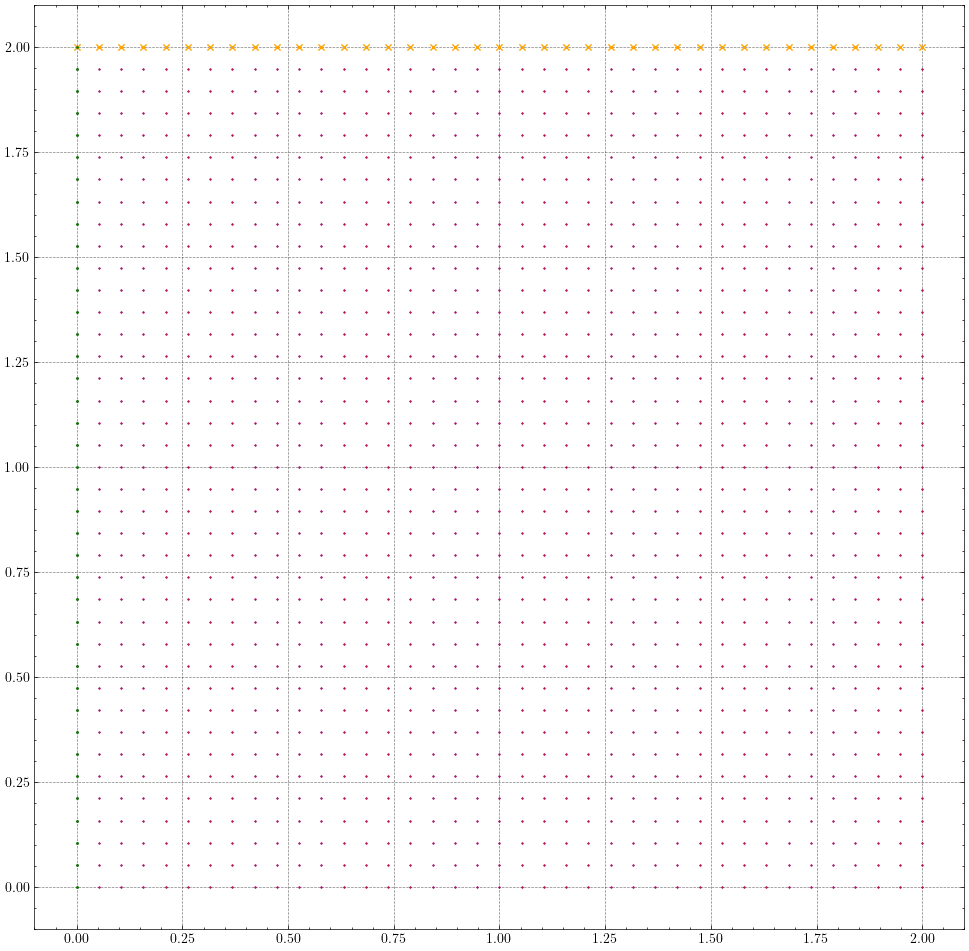

In [107]:
fig, axes = plt.subplots(figsize=(12,12))
axes.scatter(velocity_coordinates[:,0], velocity_coordinates[:,1], s=0.2, color='blue')
axes.scatter(pressure_coordinates[:,0], pressure_coordinates[:,1], s=0.2, color='red')
axes.scatter(velocity_coordinates[top_indices,0], velocity_coordinates[top_indices,1], marker='x', color='orange', s=20)
axes.scatter(pressure_coordinates[left_indicesp,0], pressure_coordinates[left_indicesp,1], marker='o', color='green', s=1)
plt.show()

In [108]:
@fem.LinearForm
def F_1_1(v,w):
    C1 = grad(v)[0]*(-(nu/2)*grad(w.u_0)[0] - (nu/2)*grad(w.u_1)[0])
    C2 = grad(v)[1]*(-(nu/2)*grad(w.u_0)[1] - (nu/2)*grad(w.u_1)[1])
    C3 = v*(-0.5*w.u_0*grad(w.u_0)[0] - 0.5*w.u_1*grad(w.u_1)[0] - 0.5*w.v_0*grad(w.u_0)[1] - 0.5*w.v_1*grad(w.u_1)[1] + (1/dt)*w.u_0 - (1/dt)*w.u_1)
    return C1 + C2 + C3

@fem.LinearForm
def F_1_2(v,w):
    return v*(-(0.5/rho)*grad(w.p_0)[0] - (0.5/rho)*grad(w.p_1)[0])

@fem.LinearForm
def boundary_F1(v,w):
    return (0.5*nu*w.n[0]*grad(w.u_0)[0] + 0.5*nu*w.n[0]*grad(w.u_1)[0] + 0.5*nu*w.n[1]*grad(w.u_0)[1] + 0.5*nu*w.n[1]*grad(w.u_1)[1])*v

@fem.LinearForm
def F_2_1(v,w):
    C1 = grad(v)[0]*(-(nu/2)*grad(w.v_0)[0] - (nu/2)*grad(w.v_1)[0])
    C2 = grad(v)[1]*(-(nu/2)*grad(w.v_0)[1] - (nu/2)*grad(w.v_1)[1])
    C3 = v*(-0.5*w.u_0*grad(w.v_0)[0] - 0.5*w.u_1*grad(w.v_1)[0] - 0.5*w.v_0*grad(w.v_0)[1] - 0.5*w.v_1*grad(w.v_1)[1] + (1/dt)*w.v_0 - (1/dt)*w.v_1)
    return C1 + C2 + C3

@fem.LinearForm
def F_2_2(v,w):
    return v*(-(0.5/rho)*grad(w.p_0)[1] - (0.5/rho)*grad(w.p_1)[1])

@fem.LinearForm
def boundary_F2(v,w):
    return (0.5*nu*w.n[0]*grad(w.v_0)[0] + 0.5*nu*w.n[0]*grad(w.v_1)[0] + 0.5*nu*w.n[1]*grad(w.v_0)[1] + 0.5*nu*w.n[1]*grad(w.v_1)[1])*v

@fem.LinearForm
def F_3_1(v,w):
    C1 = v*(-0.25*rho*(grad(w.u_0)[0]**2) - 0.5*rho*grad(w.u_0)[0]*grad(w.u_1)[0] - 0.5*rho*grad(w.u_0)[1]*grad(w.v_0)[0] - 0.5*rho*grad(w.u_0)[1]*grad(w.v_1)[0] - 0.25*rho*(grad(w.u_1)[0]**2))
    C2 = v*(-0.5*rho*grad(w.u_1)[1]*grad(w.v_0)[0] - 0.5*rho*grad(w.u_1)[1]*grad(w.v_1)[0] - 0.25*rho*(grad(w.v_0)[1]**2) - 0.5*rho*grad(w.v_0)[1]*grad(w.v_1)[1] - 0.25*rho*(grad(w.v_1)[1]**2))
    return C1 + C2

@fem.LinearForm
def F_3_2(v,w):
    C1 = grad(v)[0]*(0.5*grad(w.p_0)[0] + 0.5*grad(w.p_1)[0])
    C2 = grad(v)[1]*(0.5*grad(w.p_0)[1] + 0.5*grad(w.p_1)[1])
    return C1+C2

@fem.LinearForm
def boundary_F3(v,w):
    return (-0.5*w.n[0]*grad(w.p_0)[0] - 0.5*w.n[0]*grad(w.p_1)[0] - 0.5*w.n[1]*grad(w.p_0)[1] - 0.5*w.n[1]*grad(w.p_1)[1])*v


In [109]:
sp.collect(greened_FEQ3, [k,j])

(0.5*Derivative(p^n(x, y), x) + 0.5*Derivative(p^{n+1}(x, y), x))*Derivative(j(x, y), x) + (0.5*Derivative(p^n(x, y), y) + 0.5*Derivative(p^{n+1}(x, y), y))*Derivative(j(x, y), y) + (-0.5*n_1(x, y)*Derivative(p^n(x, y), x) - 0.5*n_1(x, y)*Derivative(p^{n+1}(x, y), x) - 0.5*n_2(x, y)*Derivative(p^n(x, y), y) - 0.5*n_2(x, y)*Derivative(p^{n+1}(x, y), y))*j(x, y) + (-0.25*\rho*Derivative(u^n(x, y), x)**2 - 0.5*\rho*Derivative(u^n(x, y), x)*Derivative(u^{n+1}(x, y), x) - 0.5*\rho*Derivative(u^n(x, y), y)*Derivative(v^n(x, y), x) - 0.5*\rho*Derivative(u^n(x, y), y)*Derivative(v^{n+1}(x, y), x) - 0.25*\rho*Derivative(u^{n+1}(x, y), x)**2 - 0.5*\rho*Derivative(u^{n+1}(x, y), y)*Derivative(v^n(x, y), x) - 0.5*\rho*Derivative(u^{n+1}(x, y), y)*Derivative(v^{n+1}(x, y), x) - 0.25*\rho*Derivative(v^n(x, y), y)**2 - 0.5*\rho*Derivative(v^n(x, y), y)*Derivative(v^{n+1}(x, y), y) - 0.25*\rho*Derivative(v^{n+1}(x, y), y)**2)*k(x, y)

In [110]:
@fem.BilinearForm
def J_11(u,v,w):
    C1 = grad(v)[0]*(-nu/2)*grad(u)[0]
    C2 = grad(v)[1]*(-nu/2)*grad(u)[1]
    C3 = v*(-(1/2)*u*grad(w.u_1)[0] - (1/2)*w.u_1*grad(u)[0] - (1/2)*w.v_1*grad(u)[1] - (1/dt)*u)
    return C1 + C2 + C3

@fem.BilinearForm
def boundary_J11(u,v,w):
    return ((nu/2)*w.n[0]*grad(u)[0] + (nu/2)*w.n[1]*grad(u)[1])*v

@fem.BilinearForm
def J_12(u,v,w):
    return (-1/2)*u*v*grad(w.u_1)[1]

@fem.BilinearForm
def J_13(u,v,w):
    return -(1/(2*rho))*grad(u)[0]*v

@fem.BilinearForm
def J_21(u,v,w):
    return -(1/2)*u*v*grad(w.v_1)[0]

@fem.BilinearForm
def J_22(u,v,w):
    C1 = grad(v)[0]*(-nu/2)*grad(u)[0]
    C2 = grad(v)[1]*(-nu/2)*grad(u)[1]
    C3 = v*(-(1/2)*u*grad(w.v_1)[1] - (1/2)*w.u_1*grad(u)[0] - (1/2)*w.v_1*grad(u)[1] - (1/dt)*u)
    return C1 + C2 + C3

@fem.BilinearForm
def boundary_J22(u,v,w):
    return ((nu/2)*w.n[0]*grad(u)[0] + (nu/2)*w.n[1]*grad(u)[1])*v

@fem.BilinearForm
def J_23(u,v,w):
    return (-1/(2*rho))*grad(u)[1]*v

@fem.BilinearForm
def J_31(u,v,w):
    C1 = v*(-(rho/2)*grad(u)[0]*grad(w.u_0)[0] - (rho/2)*grad(u)[0]*grad(w.u_1)[0] - (rho/2)*grad(u)[1]*grad(w.v_0)[0] - (rho/2)*grad(u)[1]*grad(w.v_1)[0])
    return C1

@fem.BilinearForm
def J_32(u,v,w):
    C1 = v*(-(rho/2)*grad(u)[0]*grad(w.u_0)[1] - (rho/2)*grad(u)[0]*grad(w.u_1)[1] - (rho/2)*grad(u)[1]*grad(w.v_0)[1] - (rho/2)*grad(u)[1]*grad(w.v_1)[1])
    return C1

@fem.BilinearForm
def J_33(u,v,w):
    # return (1/2)*grad(u)[0]*grad(v)[0] + (1/2)*grad(u)[1]*grad(v)[1]
    return (1/2)*dot(grad(u), grad(v))

@fem.BilinearForm
def boundary_J33(u,v,w):
    return ((-1/2)*w.n[0]*grad(u)[0] - (1/2)*w.n[1]*grad(u)[1])*v

In [111]:
sp.collect(J23_lim.expand(), [k,j])

-j(x, y)*Derivative(\hat{p}(x, y), y)/(2*\rho)

In [112]:
sp.collect(J11_lim.expand(), [k,j])

-\nu*Derivative(\hat{u}(x, y), x)*Derivative(k(x, y), x)/2 - \nu*Derivative(\hat{u}(x, y), y)*Derivative(k(x, y), y)/2 + (\nu*n_1(x, y)*Derivative(\hat{u}(x, y), x)/2 + \nu*n_2(x, y)*Derivative(\hat{u}(x, y), y)/2 - \hat{u}(x, y)*Derivative(u^{n+1}(x, y), x)/2 - u^{n+1}(x, y)*Derivative(\hat{u}(x, y), x)/2 - v^{n+1}(x, y)*Derivative(\hat{u}(x, y), y)/2 - \hat{u}(x, y)/\Delta_t)*k(x, y)

In [113]:
u_previous = u_fields[0,:]
v_previous = v_fields[0,:]
p_previous = p_fields[0,:]

u_guess = u_previous
v_guess = v_previous
p_guess = p_previous

def get_functional(u_guess, v_guess, p_guess, u_previous, v_previous, p_previous):
    part_1 = F_1_1.assemble(basis_velocity, u_1 = basis_velocity.interpolate(u_guess), u_0 = basis_velocity.interpolate(u_previous), v_1 = basis_velocity.interpolate(v_guess), v_0 = basis_velocity.interpolate(v_previous))
    part_2 = F_1_2.assemble(basis_pressure, p_1 = basis_pressure.interpolate(p_guess), p_0 = basis_pressure.interpolate(p_previous))

    u_left = boundary_F1.assemble(gamma1_basis_velocity, u_1 = gamma1_basis_velocity.interpolate(u_guess), u_0 = gamma1_basis_velocity.interpolate(u_previous), v_1 = gamma1_basis_velocity.interpolate(v_guess), v_0 = gamma1_basis_velocity.interpolate(v_previous))
    u_top =  boundary_F1.assemble(gamma2_basis_velocity, u_1 = gamma2_basis_velocity.interpolate(u_guess), u_0 = gamma2_basis_velocity.interpolate(u_previous), v_1 = gamma2_basis_velocity.interpolate(v_guess), v_0 = gamma2_basis_velocity.interpolate(v_previous))
    u_right = boundary_F1.assemble(gamma3_basis_velocity, u_1 = gamma3_basis_velocity.interpolate(u_guess), u_0 = gamma3_basis_velocity.interpolate(u_previous), v_1 = gamma3_basis_velocity.interpolate(v_guess), v_0 = gamma3_basis_velocity.interpolate(v_previous))
    u_bot = boundary_F1.assemble(gamma4_basis_velocity, u_1 = gamma4_basis_velocity.interpolate(u_guess), u_0 = gamma4_basis_velocity.interpolate(u_previous), v_1 = gamma4_basis_velocity.interpolate(v_guess), v_0 = gamma4_basis_velocity.interpolate(v_previous))

    part_3 = F_2_1.assemble(basis_velocity, u_1 = basis_velocity.interpolate(u_guess), u_0 = basis_velocity.interpolate(u_previous), v_1 = basis_velocity.interpolate(v_guess), v_0 = basis_velocity.interpolate(v_previous))
    part_4 = F_2_2.assemble(basis_pressure, p_1 = basis_pressure.interpolate(p_guess), p_0 = basis_pressure.interpolate(p_previous))

    v_left = boundary_F2.assemble(gamma1_basis_velocity, u_1 = gamma1_basis_velocity.interpolate(u_guess), u_0 = gamma1_basis_velocity.interpolate(u_previous), v_1 = gamma1_basis_velocity.interpolate(v_guess), v_0 = gamma1_basis_velocity.interpolate(v_previous))
    v_top = boundary_F2.assemble(gamma2_basis_velocity, u_1 = gamma2_basis_velocity.interpolate(u_guess), u_0 = gamma2_basis_velocity.interpolate(u_previous), v_1 = gamma2_basis_velocity.interpolate(v_guess), v_0 = gamma2_basis_velocity.interpolate(v_previous))
    v_right = boundary_F2.assemble(gamma3_basis_velocity, u_1 = gamma3_basis_velocity.interpolate(u_guess), u_0 = gamma3_basis_velocity.interpolate(u_previous), v_1 = gamma3_basis_velocity.interpolate(v_guess), v_0 = gamma3_basis_velocity.interpolate(v_previous))
    v_bot = boundary_F2.assemble(gamma4_basis_velocity, u_1 = gamma4_basis_velocity.interpolate(u_guess), u_0 = gamma4_basis_velocity.interpolate(u_previous), v_1 = gamma4_basis_velocity.interpolate(v_guess), v_0 = gamma4_basis_velocity.interpolate(v_previous))

    part_5 = F_3_1.assemble(basis_velocity, u_1 = basis_velocity.interpolate(u_guess), u_0 = basis_velocity.interpolate(u_previous), v_1 = basis_velocity.interpolate(v_guess), v_0 = basis_velocity.interpolate(v_previous))
    part_6 = F_3_2.assemble(basis_pressure, p_1 = basis_pressure.interpolate(p_guess), p_0 = basis_pressure.interpolate(p_previous))

    # p_left = boundary_F3.assemble(gamma1_basis_pressure, p_1 = gamma1_basis_pressure.interpolate(p_guess), p_0 = gamma1_basis_pressure.interpolate(p_previous))
    p_top = boundary_F3.assemble(gamma2_basis_pressure, p_1 = gamma2_basis_pressure.interpolate(p_guess), p_0 = gamma2_basis_pressure.interpolate(p_previous))
    # p_right = boundary_F3.assemble(gamma3_basis_pressure, p_1 = gamma3_basis_pressure.interpolate(p_guess), p_0 = gamma3_basis_pressure.interpolate(p_previous))
    # p_bot = boundary_F3.assemble(gamma4_basis_pressure, p_1 = gamma4_basis_pressure.interpolate(p_guess), p_0 = gamma4_basis_pressure.interpolate(p_previous))
    
    return np.concatenate((part_1 + part_2 + u_left + u_top + u_right + u_bot, part_3 + part_4 + v_left + v_top + v_right + v_bot, part_5 + part_6 + p_top))
    # return np.concatenate((part_1 + part_3 + part_5, part_2 + part_4 + part_6))

def get_jacobian(u_guess, v_guess, p_guess, u_previous, v_previous, p_previous):
    part_1 = J_11.assemble(basis_velocity, u_1 = basis_velocity.interpolate(u_guess), u_0 = basis_velocity.interpolate(u_previous), v_1 = basis_velocity.interpolate(v_guess), v_0 = basis_velocity.interpolate(v_previous))
    part_2 = J_12.assemble(basis_velocity, u_1 = basis_velocity.interpolate(u_guess), u_0 = basis_velocity.interpolate(u_previous), v_1 = basis_velocity.interpolate(v_guess), v_0 = basis_velocity.interpolate(v_previous))
    part_3 = J_13.assemble(basis_pressure)

    u_left = boundary_J11.assemble(gamma1_basis_velocity, u_1 = gamma1_basis_velocity.interpolate(u_guess), u_0 = gamma1_basis_velocity.interpolate(u_previous), v_1 = gamma1_basis_velocity.interpolate(v_guess), v_0 = gamma1_basis_velocity.interpolate(v_previous))
    u_top = boundary_J11.assemble(gamma2_basis_velocity, u_1 = gamma2_basis_velocity.interpolate(u_guess), u_0 = gamma2_basis_velocity.interpolate(u_previous), v_1 = gamma2_basis_velocity.interpolate(v_guess), v_0 = gamma2_basis_velocity.interpolate(v_previous))
    u_right = boundary_J11.assemble(gamma3_basis_velocity, u_1 = gamma3_basis_velocity.interpolate(u_guess), u_0 = gamma3_basis_velocity.interpolate(u_previous), v_1 = gamma3_basis_velocity.interpolate(v_guess), v_0 = gamma3_basis_velocity.interpolate(v_previous))
    u_bot = boundary_J11.assemble(gamma4_basis_velocity, u_1 = gamma4_basis_velocity.interpolate(u_guess), u_0 = gamma4_basis_velocity.interpolate(u_previous), v_1 = gamma4_basis_velocity.interpolate(v_guess), v_0 = gamma4_basis_velocity.interpolate(v_previous))

    part_4 = J_21.assemble(basis_velocity, u_1 = basis_velocity.interpolate(u_guess), u_0 = basis_velocity.interpolate(u_previous), v_1 = basis_velocity.interpolate(v_guess), v_0 = basis_velocity.interpolate(v_previous))
    part_5 = J_22.assemble(basis_velocity, u_1 = basis_velocity.interpolate(u_guess), u_0 = basis_velocity.interpolate(u_previous), v_1 = basis_velocity.interpolate(v_guess), v_0 = basis_velocity.interpolate(v_previous))
    part_6 = J_23.assemble(basis_pressure)

    v_left = boundary_J22.assemble(gamma1_basis_velocity, u_1 = gamma1_basis_velocity.interpolate(u_guess), u_0 = gamma1_basis_velocity.interpolate(u_previous), v_1 = gamma1_basis_velocity.interpolate(v_guess), v_0 = gamma1_basis_velocity.interpolate(v_previous))
    v_top = boundary_J22.assemble(gamma2_basis_velocity, u_1 = gamma2_basis_velocity.interpolate(u_guess), u_0 = gamma2_basis_velocity.interpolate(u_previous), v_1 = gamma2_basis_velocity.interpolate(v_guess), v_0 = gamma2_basis_velocity.interpolate(v_previous))
    v_right = boundary_J22.assemble(gamma3_basis_velocity, u_1 = gamma3_basis_velocity.interpolate(u_guess), u_0 = gamma3_basis_velocity.interpolate(u_previous), v_1 = gamma3_basis_velocity.interpolate(v_guess), v_0 = gamma3_basis_velocity.interpolate(v_previous))
    v_bot =boundary_J22.assemble(gamma4_basis_velocity, u_1 = gamma4_basis_velocity.interpolate(u_guess), u_0 = gamma4_basis_velocity.interpolate(u_previous), v_1 = gamma4_basis_velocity.interpolate(v_guess), v_0 = gamma4_basis_velocity.interpolate(v_previous))

    part_7 = J_31.assemble(basis_velocity, u_1 = basis_velocity.interpolate(u_guess), u_0 = basis_velocity.interpolate(u_previous), v_1 = basis_velocity.interpolate(v_guess), v_0 = basis_velocity.interpolate(v_previous))
    part_8 = J_32.assemble(basis_velocity, u_1 = basis_velocity.interpolate(u_guess), u_0 = basis_velocity.interpolate(u_previous), v_1 = basis_velocity.interpolate(v_guess), v_0 = basis_velocity.interpolate(v_previous))
    part_9 = J_33.assemble(basis_pressure)

    # p_left = boundary_J33.assemble(gamma1_basis_pressure, p_1 = gamma1_basis_pressure.interpolate(p_guess), p_0 = gamma1_basis_pressure.interpolate(p_previous))
    p_top = boundary_J33.assemble(gamma2_basis_pressure, p_1 = gamma2_basis_pressure.interpolate(p_guess), p_0 = gamma2_basis_pressure.interpolate(p_previous))
    # p_right = boundary_J33.assemble(gamma3_basis_pressure, p_1 = gamma3_basis_pressure.interpolate(p_guess), p_0 = gamma3_basis_pressure.interpolate(p_previous))
    # p_bot = boundary_J33.assemble(gamma4_basis_pressure, p_1 = gamma4_basis_pressure.interpolate(p_guess), p_0 = gamma4_basis_pressure.interpolate(p_previous))

    complete = scsparse.block_array([[part_1 + u_left + u_top + u_right + u_bot, part_2,part_3],[part_4,part_5 + v_left + v_top + v_right + v_bot,part_6],[part_7,part_8,part_9+p_top]]) 
    # nugget = scsparse.csr_array(1e-6*np.eye(np.shape(complete)[0]))
    
    return complete

# for i in tqdm(range(number_of_steps-1)):
#     du_norm = 1.
#     while du_norm > newton_tol:
#         # calculate the residual, with the next u_k being our guess, and u_0 being the previous point
#         u_k_resid = F_functional.assemble(basis, u_k = basis.interpolate(u_guess), u_0 = basis.interpolate(u_strue[i,:]))
#         # set boundary conditions
#         u_k_resid[0] = u_k_resid[-1] = 0.
#         j_mat = F_jacobian.assemble(basis, u_k = basis.interpolate(u_guess), u_0 = basis.interpolate(u_strue[i,:]))
#         j_mat[0,:] = j_mat[-1,:] = 0.
#         j_mat[0,0] = j_mat[-1,-1] = 1.
#         du_norm = np.linalg.norm(u_k_resid)
#         u_guess = u_guess + scsparse.linalg.spsolve(j_mat, -u_k_resid)
#     u_strue[i+1,:] = u_guess

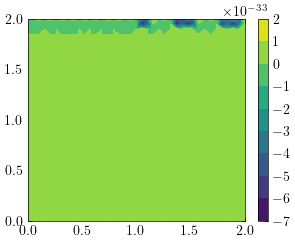

In [114]:
plt.tricontourf(xsv, ysv, F_3_1.assemble(basis_velocity, u_1 = basis_velocity.interpolate(u_guess), u_0 = basis_velocity.interpolate(u_previous), v_1 = basis_velocity.interpolate(v_guess), v_0 = basis_velocity.interpolate(v_previous)))
plt.colorbar()

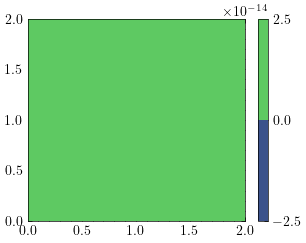

In [115]:
plt.tricontourf(xsv, ysv, F_3_2.assemble(basis_pressure, p_1 = basis_pressure.interpolate(p_guess), p_0 = basis_pressure.interpolate(p_previous)))
plt.colorbar()

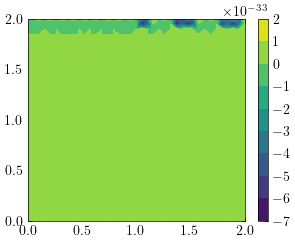

In [116]:
plt.tricontourf(xsv, ysv, F_3_1.assemble(basis_velocity, u_1 = basis_velocity.interpolate(u_guess), u_0 = basis_velocity.interpolate(u_previous), v_1 = basis_velocity.interpolate(v_guess), v_0 = basis_velocity.interpolate(v_previous)) + F_3_2.assemble(basis_pressure, p_1 = basis_pressure.interpolate(p_guess), p_0 = basis_pressure.interpolate(p_previous)))
plt.colorbar()

RuntimeError: Error in qhull Delaunay triangulation calculation: singular input data (exitcode=2); use python verbose option (-v) to see original qhull error.

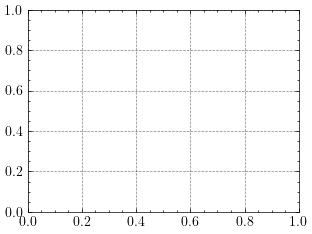

In [117]:
plt.tricontourf(xs, ys, boundary_F3.assemble(gamma2_basis_pressure, p_1 = gamma2_basis_pressure.interpolate(p_guess), p_0 = gamma2_basis_pressure.interpolate(p_previous)))
plt.colorbar()

In [118]:
print(u_bottom_indices)
print(u_top_indices)
print(u_left_indices)
print(u_right_indices)

[   0   20   40   60   80  100  120  140  160  180  200  220  240  260
  280  300  320  340  360  380  401  459  517  575  633  691  749  807
  865  923  981 1039 1097 1155 1213 1271 1329 1387 1445]
[  19   39   59   79   99  119  139  159  179  199  219  239  259  279
  299  319  339  359  379  399  457  515  573  631  689  747  805  863
  921  979 1037 1095 1153 1211 1269 1327 1385 1443 1501]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19 400 403 406 409 412 415 418 421 424 427 430 433 436 439 442 445
 448 451 454]
[ 380  381  382  383  384  385  386  387  388  389  390  391  392  393
  394  395  396  397  398  399 1502 1503 1504 1505 1506 1507 1508 1509
 1510 1511 1512 1513 1514 1515 1516 1517 1518 1519 1520]


In [119]:
print(v_bottom_indices)
print(v_top_indices)
print(v_left_indices)
print(v_right_indices)

[1521 1541 1561 1581 1601 1621 1641 1661 1681 1701 1721 1741 1761 1781
 1801 1821 1841 1861 1881 1901 1922 1980 2038 2096 2154 2212 2270 2328
 2386 2444 2502 2560 2618 2676 2734 2792 2850 2908 2966]
[1540 1560 1580 1600 1620 1640 1660 1680 1700 1720 1740 1760 1780 1800
 1820 1840 1860 1880 1900 1920 1978 2036 2094 2152 2210 2268 2326 2384
 2442 2500 2558 2616 2674 2732 2790 2848 2906 2964 3022]
[1521 1522 1523 1524 1525 1526 1527 1528 1529 1530 1531 1532 1533 1534
 1535 1536 1537 1538 1539 1540 1921 1924 1927 1930 1933 1936 1939 1942
 1945 1948 1951 1954 1957 1960 1963 1966 1969 1972 1975]
[1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914
 1915 1916 1917 1918 1919 1920 3023 3024 3025 3026 3027 3028 3029 3030
 3031 3032 3033 3034 3035 3036 3037 3038 3039 3040 3041]


In [120]:
print(p_bottom_indices)
print(p_top_indices)
print(p_left_indices)
print(p_right_indices)

[3042 3062 3082 3102 3122 3142 3162 3182 3202 3222 3242 3262 3282 3302
 3322 3342 3362 3382 3402 3422 3443 3501 3559 3617 3675 3733 3791 3849
 3907 3965 4023 4081 4139 4197 4255 4313 4371 4429 4487]
[3061 3081 3101 3121 3141 3161 3181 3201 3221 3241 3261 3281 3301 3321
 3341 3361 3381 3401 3421 3441 3499 3557 3615 3673 3731 3789 3847 3905
 3963 4021 4079 4137 4195 4253 4311 4369 4427 4485 4543]
[3042 3043 3044 3045 3046 3047 3048 3049 3050 3051 3052 3053 3054 3055
 3056 3057 3058 3059 3060 3061 3442 3445 3448 3451 3454 3457 3460 3463
 3466 3469 3472 3475 3478 3481 3484 3487 3490 3493 3496]
[3422 3423 3424 3425 3426 3427 3428 3429 3430 3431 3432 3433 3434 3435
 3436 3437 3438 3439 3440 3441 4544 4545 4546 4547 4548 4549 4550 4551
 4552 4553 4554 4555 4556 4557 4558 4559 4560 4561 4562]


In [121]:
u_guesses = []
v_guesses = []
p_guesses = []

divergences = []

newton_tol = 1e-6
for i in tqdm(range(time_steps-1)):
    du_norm = 1.
    u_previous, v_previous, p_previous = u_fields[i, :], v_fields[i,:], p_fields[i,:]
    while du_norm > newton_tol:
    # for j in range(10):
        previous_guess = np.concatenate((u_guess, v_guess, p_guess))
        u_guess, v_guess, p_guess = np.split(previous_guess, 3)
        state_residual = get_functional(u_guess, v_guess, p_guess, u_previous, v_previous, p_previous)
        state_jacobian = get_jacobian(u_guess, v_guess, p_guess, u_previous, v_previous, p_previous).tolil()

        state_residual[u_bottom_indices] = u_guess[bottom_indices]
        state_residual[u_left_indices] = u_guess[left_indices]
        state_residual[u_right_indices] = u_guess[right_indices]
        state_residual[v_bottom_indices] = v_guess[bottom_indices]
        state_residual[v_right_indices] = v_guess[right_indices]
        state_residual[v_left_indices] = v_guess[left_indices]
        state_residual[v_top_indices] = v_guess[top_indices]
        state_residual[p_top_indices] = p_guess[top_indices] - reference_pressure
        state_residual[u_top_indices] = u_guess[top_indices] - lid_velocity

        state_jacobian[u_top_indices,:] =  state_jacobian[u_left_indices,:] = state_jacobian[u_right_indices,:] = 0.
        state_jacobian[u_bottom_indices,:] = 0.
        state_jacobian[u_top_indices,u_top_indices] =  state_jacobian[u_left_indices,u_left_indices] = state_jacobian[u_right_indices,u_right_indices] = 1.
        state_jacobian[u_bottom_indices,u_bottom_indices] = 1.
        state_jacobian[v_top_indices,:] = state_jacobian[v_bottom_indices,:] = 0.
        state_jacobian[v_left_indices,:] = state_jacobian[v_right_indices,:] = 0.
        state_jacobian[v_top_indices,v_top_indices] = state_jacobian[v_bottom_indices,v_bottom_indices] = 1.
        state_jacobian[v_left_indices,v_left_indices] = state_jacobian[v_right_indices,v_right_indices] = 1.
        state_jacobian[p_top_indices,:] = 0.
        state_jacobian[p_top_indices, p_top_indices] = 1.

        state_jacobian = state_jacobian.tocsr()
        # state_jacobian = state_jacobian.toarray()
        # current_guess = np.concatenate((u_guess, v_guess, p_guess))
        
        new_delta = scsparse.linalg.spsolve(state_jacobian, -state_residual)
        # new_delta = np.linalg.solve(state_jacobian, -state_residual)
        current_guess = previous_guess + new_delta
        # du_norm = np.linalg.norm(current_guess - previous_guess)
        try:
            du_norm = np.linalg.norm(new_delta)
            # print(du_norm)
        except:
            pass

        previous_guess = current_guess
        # u_guess, v_guess, p_guess = np.split(current_guess, 3)
        u_guess, v_guess, p_guess = current_guess[:state_length], current_guess[state_length:2*state_length], current_guess[2*state_length:]
        u_guesses.append(u_guess)
        v_guesses.append(v_guess)
        p_guesses.append(p_guess)
    u_fields[i+1,:], v_fields[i+1,:], p_fields[i+1,:] = u_guess, v_guess, p_guess


100%|██████████| 999/999 [07:24<00:00,  2.25it/s]


In [156]:
du_norm

1.0913312664479003e-16

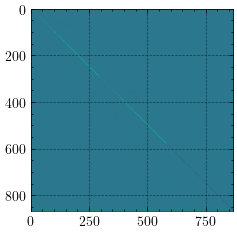

In [ ]:
plt.imshow(state_jacobian.toarray())

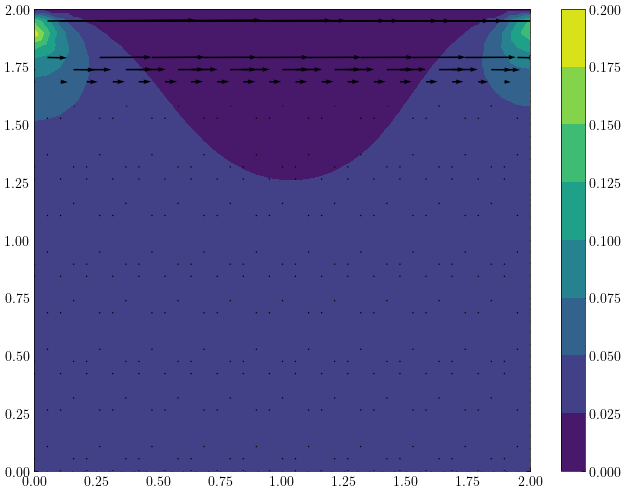

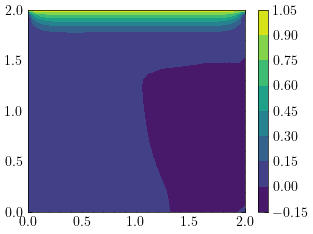

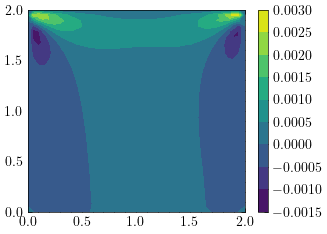

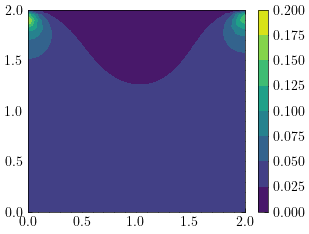

In [372]:
# coordinates = basis_pressure.doflocs.T

# import matplotlib.tri as tri
# guess = 3

# xs = coordinates[:,0]
# ys = coordinates[:,1]

# triang = tri.Triangulation(xs,ys)

# fig, axes = plt.subplots(figsize=(8,6))

# pressure = axes.tricontourf(triang, p_guesses[guess])
# fig.colorbar(pressure)
# axes.quiver(xs, ys, u_guesses[guess], v_guesses[guess])

coordinates_v = basis_velocity.doflocs.T
coordinates_p = basis_pressure.doflocs.T

import matplotlib.tri as tri
guess = -1

xs = coordinates_p[:,0]
ys = coordinates_p[:,1]

xsv = coordinates_v[:,0]
ysv = coordinates_v[:,1]

X, Y = np.meshgrid(xs, ys)

triang = tri.Triangulation(xs,ys)

fig, axes = plt.subplots(figsize=(8,6))

pressure = axes.tricontourf(xs, ys, p_guesses[guess])
fig.colorbar(pressure)
axes.quiver(xsv[::4],ysv[::4], u_guesses[guess][::4], v_guesses[guess][::4])

plt.show()

plt.tricontourf(xsv, ysv, u_guesses[guess])
plt.colorbar()
plt.show()
plt.tricontourf(xsv, ysv,v_guesses[guess])
plt.colorbar()
plt.show()
plt.tricontourf(xs, ys, p_guesses[guess])
plt.colorbar()
plt.show()


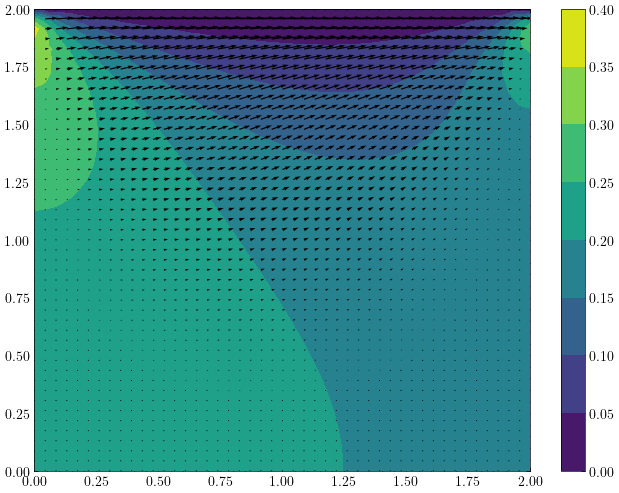

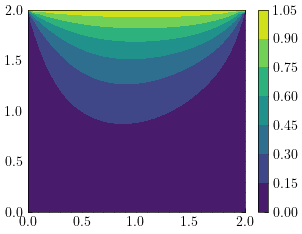

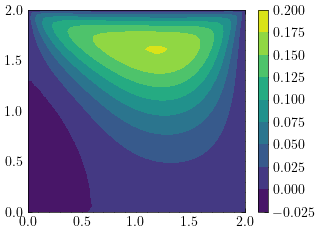

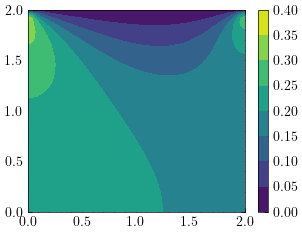

In [613]:
coordinates_v = basis_velocity.doflocs.T
coordinates_p = basis_pressure.doflocs.T

import matplotlib.tri as tri
step = 300

xs = coordinates_p[:,0]
ys = coordinates_p[:,1]

xsv = coordinates_v[:,0]
ysv = coordinates_v[:,1]

X, Y = np.meshgrid(xs, ys)

triang = tri.Triangulation(xs,ys)

fig, axes = plt.subplots(figsize=(8,6))

pressure = axes.tricontourf(xs, ys, p_fields[step, :])
fig.colorbar(pressure)
axes.quiver(xsv,ysv, u_fields[step], v_fields[step])

plt.show()

plt.tricontourf(xsv, ysv, u_fields[step, :])
plt.colorbar()
plt.show()
plt.tricontourf(xsv, ysv,v_fields[step, :])
plt.colorbar()
plt.show()
plt.tricontourf(xs, ys,p_fields[step, :])
plt.colorbar()
plt.show()

In [133]:
from scipy.interpolate import griddata
from matplotlib import colors
import matplotlib.ticker as tkr
coordinates_v = basis_velocity.doflocs.T
coordinates_p = basis_pressure.doflocs.T

xs = coordinates_p[:,0]
ys = coordinates_p[:,1]

xsv = coordinates_v[:,0]
ysv = coordinates_v[:,1]

# # Create a regular grid covering the range of the data
grid_x, grid_y = np.meshgrid(np.linspace(space_start, space_end, 100),
                            np.linspace(space_start, space_end, 100))

finalstep = 999
for step in tqdm(range(finalstep)):
# step = 45

    fig, axes = plt.subplots(1, 1, figsize=(12,12))

    filename = r"navstokeimages/" + f"{step:03}" + ".png"

    # Find the min and max pressure values for normalization
    pmin = min(p_fields[step, :].min(), p_fields[step, :].min())
    pmax = max(p_fields[step, :].max(), p_fields[step, :].max())

    # Shared normalization for pressure field
    pressure_norm = colors.Normalize(vmin=pmin, vmax=pmax)

    # Interpolate the velocity fields onto the regular grid
    # u_grid1 = griddata((xsv, ysv), u_fields[step, :], (grid_x, grid_y), method='cubic')
    # v_grid1 = griddata((xsv, ysv), v_fields[step, :], (grid_x, grid_y), method='cubic')

    # speed1 = np.sqrt(u_grid1**2 + v_grid1**2)

    # vmin = min(speed1.min(), speed1.min())
    # vmax = max(speed1.max(), speed1.max())

    # Exclude the top boundary points from colormap normalization
    masked_u = np.copy(u_fields[step, :])
    masked_v = np.copy(v_fields[step, :])

    # Mask the top points by setting their values to np.nan
    masked_u[top_indices] = np.nan
    masked_v[top_indices] = np.nan

    # Interpolate the velocity fields without the top boundary points
    u_grid1 = griddata((xsv, ysv), masked_u, (grid_x, grid_y), method='cubic')
    v_grid1 = griddata((xsv, ysv), masked_v, (grid_x, grid_y), method='cubic')

    # Calculate speed for streamlines without the top points
    speed1 = np.sqrt(u_grid1**2 + v_grid1**2)

    # Compute normalization without the top boundary points
    vmin = np.nanmin(speed1)  # Exclude np.nan
    vmax = np.nanmax(speed1)

    # Now interpolate the velocity fields again for the full streamplot (including top)
    u_grid1 = griddata((xsv, ysv), u_fields[step, :], (grid_x, grid_y), method='cubic')
    v_grid1 = griddata((xsv, ysv), v_fields[step, :], (grid_x, grid_y), method='cubic')

    # Recalculate speed for the full streamplot
    speed1 = np.sqrt(u_grid1**2 + v_grid1**2)
    
    # Create a shared normalization instance
    norm = colors.Normalize(vmin=vmin, vmax=vmax)


    # Plot tricontourf and streamplot for the first timestep
    contour1 = axes.tricontourf(xs, ys, p_fields[step, :], levels=14, norm=pressure_norm)
    strm1 = axes.streamplot(grid_x, grid_y, u_grid1, v_grid1, color=speed1, cmap='cool', norm=norm, broken_streamlines=False, density=[0.75, 0.75], linewidth=0.5)
    axes.set_title(f'Time: {round(step * dt,2)}')
    axes.set_xlim(-0.1, 2.1)
    axes.set_ylim(-0.1, 2.1)

    # Add a shared colorbar for the pressure field
    cbar1 = fig.colorbar(contour1, ax=axes, orientation='vertical', format=tkr.FormatStrFormatter('%.4f'))#, fraction=0.02, pad=0.04)
    cbar1.set_label('Pressure')

    cbar2 = fig.colorbar(strm1.lines, ax=axes, orientation='horizontal', format=tkr.FormatStrFormatter('%.4f'))#, fraction=0.02, pad=0.04)
    cbar2.set_label('Speed')

    # Adjust layout and show the plot
    # plt.tight_layout()
    plt.savefig(filename)
    plt.close()

 37%|███▋      | 374/999 [08:12<48:16,  4.63s/it]  

: 

In [130]:
u_grid1

array([[ 0.00000000e+00, -9.97368217e-09, -9.60546963e-09, ...,
         2.14785203e-10,  2.22996727e-10,  0.00000000e+00],
       [-3.91697300e-09,  2.64037992e-08,  7.68142517e-08, ...,
        -1.72561047e-09, -5.91031958e-10,  5.88640833e-11],
       [-3.77209905e-09,  6.93750615e-08,  1.56726525e-07, ...,
        -3.43095417e-09, -1.48866381e-09,  5.67396979e-11],
       ...,
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan]])

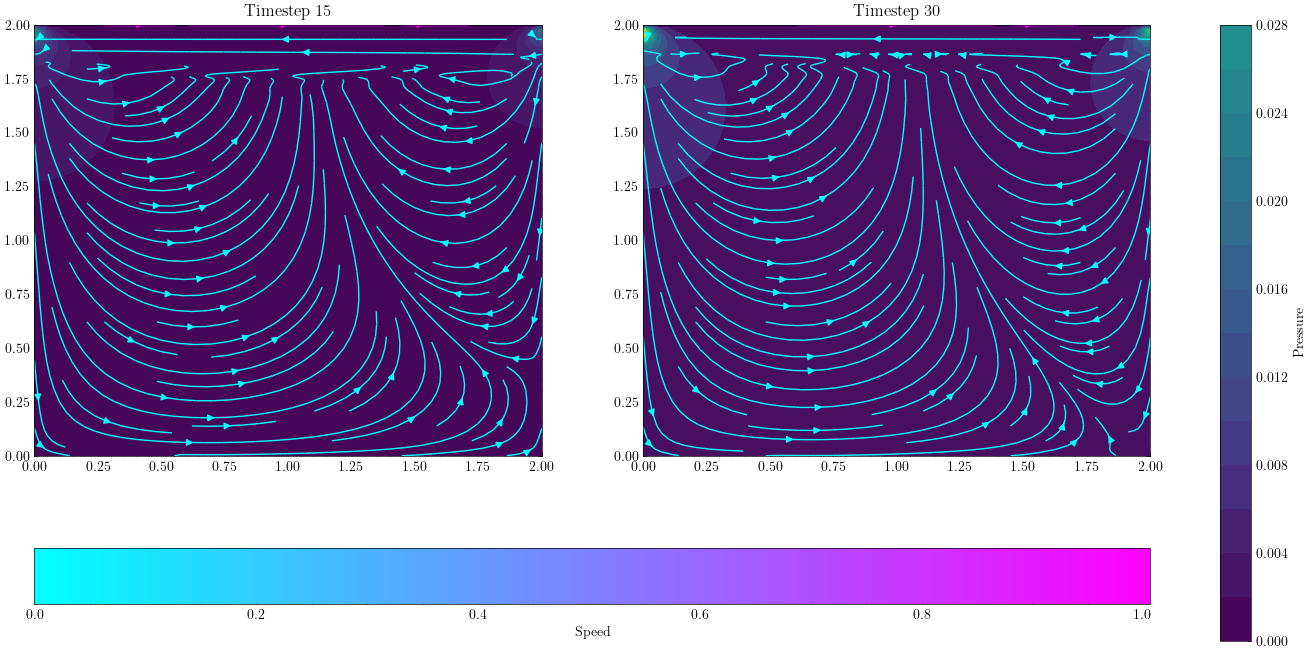

In [61]:
from scipy.interpolate import griddata
from matplotlib import colors

fig, axes = plt.subplots(1, 2, figsize=(18,8))

maxstep = 45
coordinates_v = basis_velocity.doflocs.T
coordinates_p = basis_pressure.doflocs.T

xs = coordinates_p[:,0]
ys = coordinates_p[:,1]

xsv = coordinates_v[:,0]
ysv = coordinates_v[:,1]

step1, step2 = int(round(maxstep/3)), int(round(2*maxstep/3))

# # Create a regular grid covering the range of the data
grid_x, grid_y = np.meshgrid(np.linspace(space_start, space_end, 100),
                             np.linspace(space_start, space_end, 100))

# Create a regular grid covering the range of the data
# grid_x, grid_y = np.meshgrid(np.linspace(0., 0.0075, 100),
#                              np.linspace(1.77, 1.96, 100))

# Find the min and max pressure values for normalization
pmin = min(p_fields[step1, :].min(), p_fields[step2, :].min())
pmax = max(p_fields[step1, :].max(), p_fields[step2, :].max())

# Shared normalization for pressure field
pressure_norm = colors.Normalize(vmin=pmin, vmax=pmax)

# Interpolate the velocity fields onto the regular grid
u_grid1 = griddata((xsv, ysv), u_fields[step1, :], (grid_x, grid_y), method='cubic')
v_grid1 = griddata((xsv, ysv), v_fields[step1, :], (grid_x, grid_y), method='cubic')

u_grid2 = griddata((xsv, ysv), u_fields[step2, :], (grid_x, grid_y), method='cubic')
v_grid2 = griddata((xsv, ysv), v_fields[step2, :], (grid_x, grid_y), method='cubic')

speed1 = np.sqrt(u_grid1**2 + v_grid1**2)
speed2 = np.sqrt(u_grid2**2 + v_grid2**2)

vmin = min(speed1.min(), speed2.min())
vmax = max(speed1.max(), speed2.max())
# Create a shared normalization instance
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# Plot tricontourf and streamplot for the first timestep
contour1 = axes[0].tricontourf(xs, ys, p_fields[step1, :], levels=14, norm=pressure_norm)
strm1 = axes[0].streamplot(grid_x, grid_y, u_grid1, v_grid1, color=speed1, cmap='cool', norm=norm)
axes[0].set_title(f'Timestep {step1}')
axes[0].set_xlim(0, 2)
axes[0].set_ylim(0, 2)

# Plot tricontourf and streamplot for the second timestep
contour2 = axes[1].tricontourf(xs, ys, p_fields[step2, :], levels=14, norm=pressure_norm)
strm2 = axes[1].streamplot(grid_x, grid_y, u_grid2, v_grid2, color=speed2, cmap='cool', norm=norm)
axes[1].set_title(f'Timestep {step2}')
axes[1].set_xlim(0, 2)
axes[1].set_ylim(0, 2)

# Add a shared colorbar for the pressure field
cbar1 = fig.colorbar(contour1, ax=axes, orientation='vertical')#, fraction=0.02, pad=0.04)
cbar1.set_label('Pressure')

cbar2 = fig.colorbar(strm1.lines, ax=axes, orientation='horizontal')#, fraction=0.02, pad=0.04)
cbar2.set_label('Speed')

# Adjust layout and show the plot
# plt.tight_layout()
plt.show()

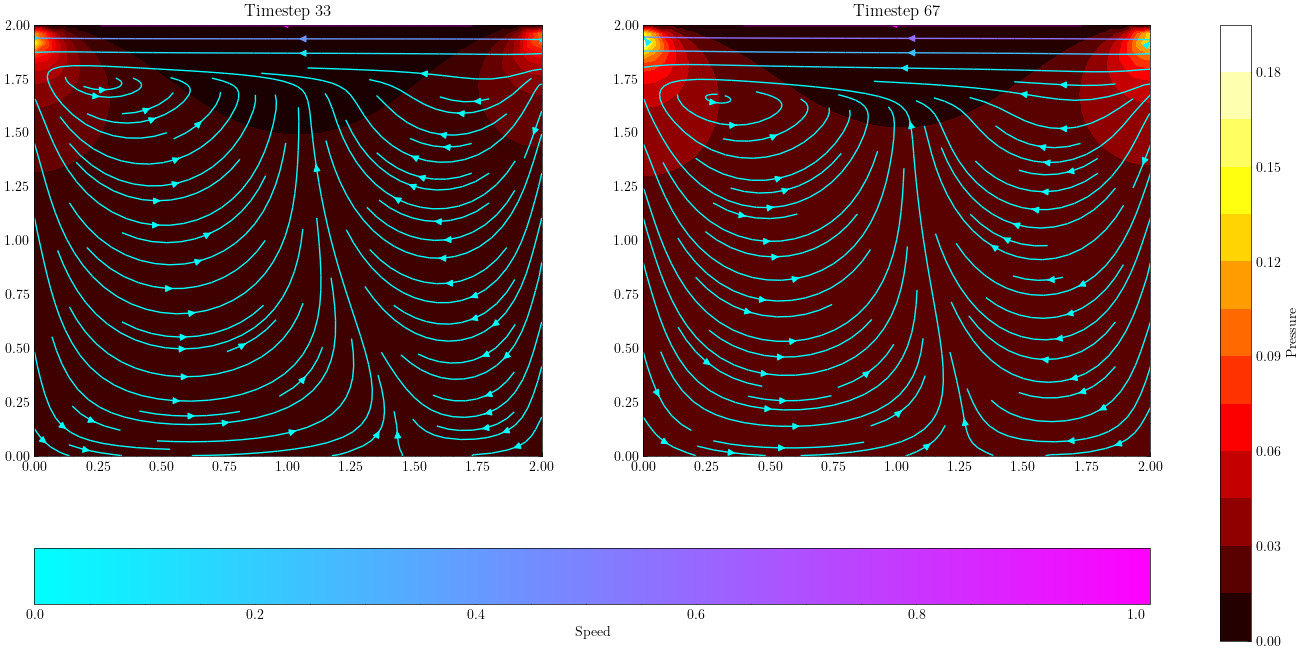

In [110]:
from scipy.interpolate import griddata
from matplotlib import colors

fig, axes = plt.subplots(1, 2, figsize=(18,8))

maxstep = 100
coordinates_v = basis_velocity.doflocs.T
coordinates_p = basis_pressure.doflocs.T

xs = coordinates_p[:,0]
ys = coordinates_p[:,1]

xsv = coordinates_v[:,0]
ysv = coordinates_v[:,1]

step1, step2 = int(round(maxstep/3)), int(round(2*maxstep/3))

# # Create a regular grid covering the range of the data
grid_x, grid_y = np.meshgrid(np.linspace(space_start, space_end, 100),
                             np.linspace(space_start, space_end, 100))

# Create a regular grid covering the range of the data
# grid_x, grid_y = np.meshgrid(np.linspace(0., 0.0075, 100),
#                              np.linspace(1.77, 1.96, 100))

# Find the min and max pressure values for normalization
pmin = min(p_fields[step1, :].min(), p_fields[step2, :].min())
pmax = max(p_fields[step1, :].max(), p_fields[step2, :].max())

# Shared normalization for pressure field
pressure_norm = colors.Normalize(vmin=pmin, vmax=pmax)

# Interpolate the velocity fields onto the regular grid
u_grid1 = griddata((xsv, ysv), u_fields[step1, :], (grid_x, grid_y), method='cubic')
v_grid1 = griddata((xsv, ysv), v_fields[step1, :], (grid_x, grid_y), method='cubic')

u_grid2 = griddata((xsv, ysv), u_fields[step2, :], (grid_x, grid_y), method='cubic')
v_grid2 = griddata((xsv, ysv), v_fields[step2, :], (grid_x, grid_y), method='cubic')

speed1 = np.sqrt(u_grid1**2 + v_grid1**2)
speed2 = np.sqrt(u_grid2**2 + v_grid2**2)

vmin = min(speed1.min(), speed2.min())
vmax = max(speed1.max(), speed2.max())
# Create a shared normalization instance
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# Plot tricontourf and streamplot for the first timestep
contour1 = axes[0].tricontourf(xs, ys, p_fields[step1, :], levels=14, cmap='hot', norm=pressure_norm)
strm1 = axes[0].streamplot(grid_x, grid_y, u_grid1, v_grid1, color=speed1, cmap='cool')
axes[0].set_title(f'Timestep {step1}')
axes[0].set_xlim(0, 2)
axes[0].set_ylim(0, 2)

# Plot tricontourf and streamplot for the second timestep
contour2 = axes[1].tricontourf(xs, ys, p_fields[step2, :], levels=14, cmap='hot', norm=pressure_norm)
strm2 = axes[1].streamplot(grid_x, grid_y, u_grid2, v_grid2, color=speed2, cmap='cool')
axes[1].set_title(f'Timestep {step2}')
axes[1].set_xlim(0, 2)
axes[1].set_ylim(0, 2)

# Add a shared colorbar for the pressure field
cbar1 = fig.colorbar(contour2, ax=axes, orientation='vertical')#, fraction=0.02, pad=0.04)
cbar1.set_label('Pressure')

cbar2 = fig.colorbar(strm1.lines, ax=axes, orientation='horizontal')#, fraction=0.02, pad=0.04)
cbar2.set_label('Speed')

# Adjust layout and show the plot
# plt.tight_layout()
plt.show()

In [703]:
len(u_fields[0,:])

6241

RuntimeError: Error in qhull Delaunay triangulation calculation: singular input data (exitcode=2); use python verbose option (-v) to see original qhull error.

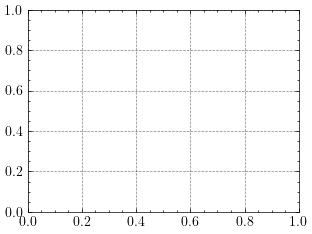

In [666]:
plt.tricontourf(xs, ys, p_fields[0, :])

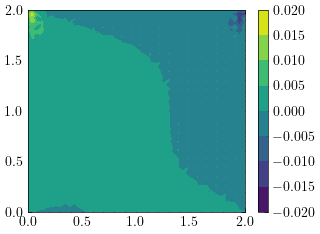

In [626]:
plt.tricontourf(triang, divergences[step-1].flatten())
plt.colorbar()

In [627]:
np.sum(divergences[step-1].flatten())

0.0

In [ ]:
from skfem.models.poisson import vector_laplace, laplace
from skfem.models.general import divergence

@fem.BilinearForm
def vector_mass(u, v, w):
    return sum(v * u)


@fem.BilinearForm
def port_pressure(u, v, w):
    return sum(v * (u * w.n))


p_inlet = 8.0

mesh = fem.MeshTri().refined(3)
# mesh.refined(4)

boundary = {
    "inlet": mesh.facets_satisfying(lambda x: x[0] == 0),
    "outlet": mesh.facets_satisfying(lambda x: x[0] == 1),
    "wall": mesh.facets_satisfying(lambda x: np.logical_or(x[1] == 0, x[1] == 1)),
}
boundary["ports"] = np.concatenate([boundary["inlet"], boundary["outlet"]])

element = {"u": fem.ElementVectorH1(fem.ElementTriP2()), "p": fem.ElementTriP1()}
basis = {
    **{v: fem.InteriorBasis(mesh, e, intorder=4) for v, e in element.items()},
    **{
        label: fem.FacetBasis(mesh, element["u"], facets=boundary[label])
        for label in ["inlet", "outlet"]
    },
}


M = fem.asm(vector_mass, basis["u"])
L = {"u": fem.asm(vector_laplace, basis["u"]), "p": fem.asm(laplace, basis["p"])}
B = -fem.asm(divergence, basis["u"], basis["p"])
P = B.T + fem.asm(
    port_pressure,
    *(
        fem.FacetBasis(mesh, element[v], facets=boundary["ports"], intorder=3)
        for v in ["p", "u"]
    )
)

t_final = 1.0
dt = 0.01

dirichlet = {
    "u": basis["u"].get_dofs(boundary["wall"]).all(),
    "p": np.concatenate([basis["p"].get_dofs(boundary["ports"]).all()]),
}
inlet_pressure_dofs = basis["p"].get_dofs(boundary["inlet"]).all()

uv_, p_ = (np.zeros(basis[v].N) for v in element.keys())  # penultimate
p__ = np.zeros_like(p_)  # antepenultimate

K = M / dt + L["u"]

t = 0

uv_field = np.zeros((int(round(t_final/dt)),578))
counter = 0
while t < t_final:

    t += dt

    # Step 1: Momentum prediction (Ern & Guermond 2002, eq. 7.40, p. 274)

    uv = fem.solve(
        *fem.condense(
            K,
            (M / dt) @ uv_ - P @ (2 * p_ - p__),
            np.zeros_like(uv_),
            D=dirichlet["u"],
        )
    )

    # Step 2: Projection (Ern & Guermond 2002, eq. 7.41, p. 274)

    dp = np.zeros(basis["p"].N)
    dp[inlet_pressure_dofs] = p_inlet - p_[inlet_pressure_dofs]

    dp = fem.solve(*fem.condense(L["p"], B @ uv, dp, D=dirichlet["p"]))

    # Step 3: Recover pressure and velocity (E. & G. 2002, p. 274)

    p = p_ + dp

    du = fem.solve(*fem.condense(M / dt, -P @ dp, D=dirichlet["u"]))
    u = uv + du

    uv_ = uv
    uv_field[counter] = uv
    counter += 1
    p_, p__ = p, p_


In [ ]:
M

<578x578 sparse matrix of type '<class 'numpy.float64'>'
	with 6146 stored elements in Compressed Sparse Row format>

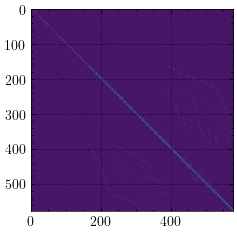

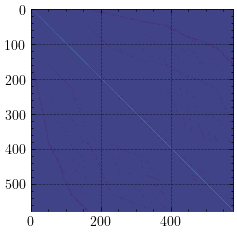

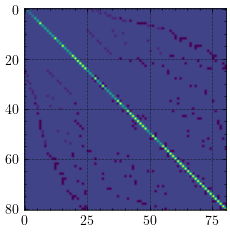

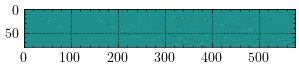

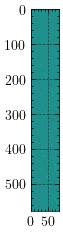

In [ ]:
plt.imshow(M.toarray())
plt.show()
plt.imshow(L['u'].toarray())
plt.show()
plt.imshow(L['p'].toarray())
plt.show()
plt.imshow(B.toarray())
plt.show()
plt.imshow(P.toarray())

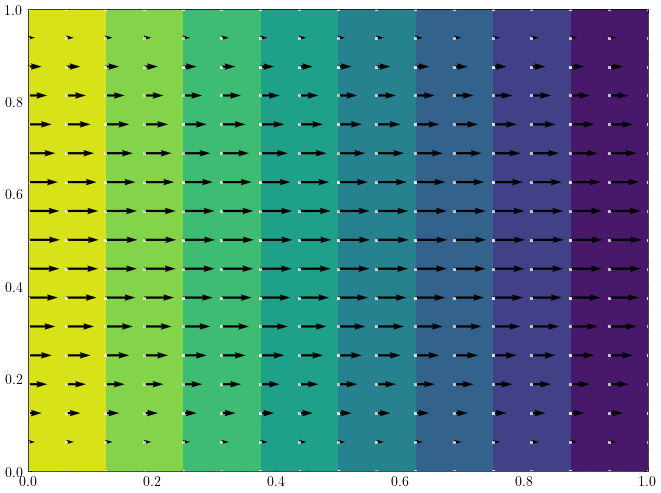

In [ ]:
coordinates = basis['u'].doflocs.T[::2]

import matplotlib.tri as tri

xs = coordinates[:,0]
ys = coordinates[:,1]

triang = tri.Triangulation(xs,ys)

fig, axes = plt.subplots(figsize=(8,6))

index = -1
u_field = uv_field[index, ::2]
v_field = uv_field[index, 1::2]

axes.tricontourf(mesh.p.T[:,0], mesh.p.T[:,1], p)
axes.quiver(xs, ys, u_field, v_field)

for coordinate in mesh.p.T:
    axes.scatter(coordinate[0],coordinate[1], color='white', alpha=0.5, s=3, marker='x')

for coordinate in basis['u'].doflocs.T:
    axes.scatter(coordinate[0],coordinate[1], color='white', alpha=0.5, s=3, marker='x')
